# Digital Signal and Image Management

## Assignment #1

Implementare la feature **Zero-crossing rate (ZCR)** per la descrizione di un segnale audio monocanale, partendo dalle istruzioni viste ad esercitazione.
Verificare l'effetto dell'uso di ZCR in combinazione con altre feature presentate ad esercitazione.

### Packages

In [12]:
#----- packages
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

plt.rcParams['figure.figsize'] = 15,5

#---- Strumenti di classificazione

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import librosa

### Premesse

Innanzitutto definiamo le feature da estrarre caricando i nostri dati. 

Tra queste abbiano:
* Media del segnale in valore assoluto
* Lunghezza del segnale
* Standard deviation del segnale
* Energia del nostro segnale
* Zero crossing rate, ovvero il numero di volte in cui il segnale attraversa lo zero

Per definire lo **zero crossing rate** si parte dalla formula:
<br>
<div align="center">
    <img src="imgs/zcr_formula.png" />
</div>

In [42]:
def identity(input):
    return input[0:100]

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def duration(input):
    return input.shape

def sdev(input):
    return np.std(input, keepdims=True)

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def zcr(input):
    return np.sum(np.abs(np.diff(np.sign(input), 1)), keepdims = True)/2

Cominciamo caricando i nostri segnali per verificare che lo **Zero-crossing rate** sia formulato in modo corretto

In [7]:
def combo(input):
    return identity(input)

Carichiamo i nostri segnali associati alle features ricavate

In [22]:
# Data loader
def load_data(feature_extractor = combo, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = load_data(normalize = True)

In [10]:
print("{n_signals} signals with length {length}".format(n_signals = len(X_train), length = len(X_train[0])))

1350 signals with length 100


Text(0.5, 1.0, 'Example of signal')

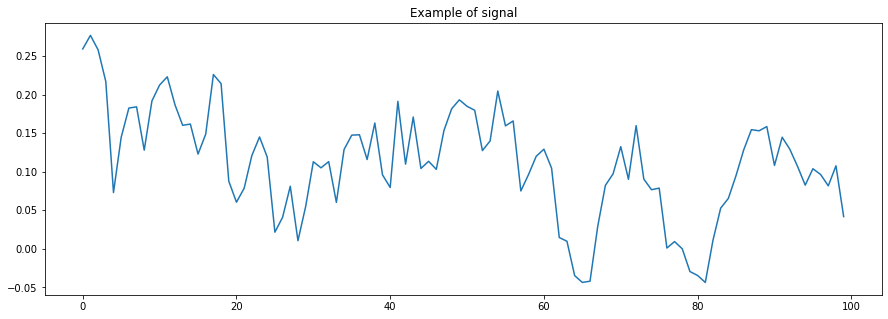

In [13]:
plt.plot(X_train[0][0:100])
plt.title("Example of signal")

Alcuni esempi per verificare la funzionalità dello **Zero-crossing rate**

In [14]:
print(zcr(X_train[0][0:100]), zcr(X_train[1][0:100]))

[4.] [8.]


Il primo segnale attraversa lo zero 4 volte, mentre il secondo lo attraversa 8 volte

Text(0.5, 1.0, 'Second signal')

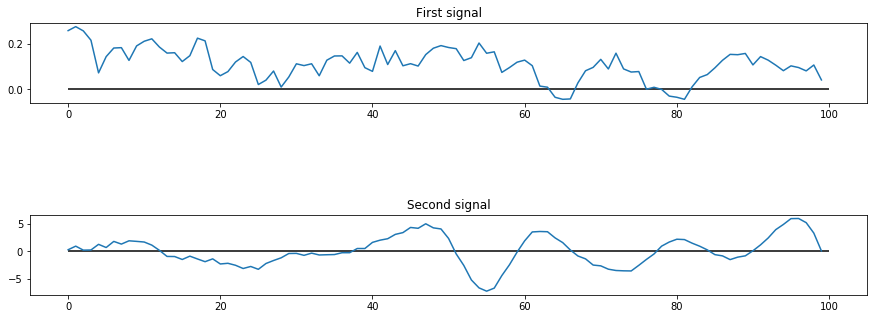

In [15]:
f, axes = plt.subplots(3, 1)
axes[0].plot(X_train[0][0:100])
axes[0].hlines(0, 0, 100)
axes[0].set_title("First signal")
axes[1].axis('off')
axes[2].plot(X_train[1][0:100])
axes[2].hlines(0, 0, 100)
axes[2].set_title("Second signal")

La formulazione sembra essere corretta

A questo punto riformuliamo la funzione "combo" per importare i nostri dati sotto forma di features riassuntive dei singoli segnali. Cominciamo riassumento il segnale attraverso **media in valore assoluto**, **deviazione standard**, **lunghezza del segnale** ed **energia del segnale**.

In [25]:
def combo(input):
    return np.concatenate((aavg(input),
                          duration(input),
                          sdev(input),
                          energy(input)))

# Data loader
def load_data(feature_extractor = combo, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = load_data(normalize=True)

In [27]:
print("{n_signals} signals with {n_features} features".format(n_signals = len(X_train), n_features = len(X_train[0])))

1350 signals with 4 features


Realiziamo un modello SVM utilizzando un approccio GridSearch per ottimizzare gli iper-parametri

In [35]:
param_grid = {'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500, 2750],
              'gamma':[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]}

In [36]:
clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid = param_grid, cv = 2)

In [37]:
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500,
                               2750],
                         'gamma': [0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                                   1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
print("Best C value: {C} \nBest gamma value: {gamma}".format(C = clf.best_params_['C'], gamma = clf.best_params_['gamma']))

Best C value: 2500 
Best gamma value: 0.25


In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.25      0.30      0.27        10
           2       0.30      0.40      0.34        15
           3       0.50      0.37      0.42        19
           4       0.27      0.36      0.31        11
           5       0.30      0.21      0.25        14
           6       0.79      0.79      0.79        14
           7       0.75      0.47      0.58        19
           8       0.33      0.35      0.34        17
           9       0.38      0.43      0.40        14

    accuracy                           0.44       150
   macro avg       0.44      0.43      0.43       150
weighted avg       0.46      0.44      0.44       150



La ricerca ha ottenuto come parametri ottimali un valore di C = 2500 e di gamma = 0.25 utilizzando una 2-folds cross validation. I risultati ottenuti sono piuttosto buoni considerando che il segnale è stato descritto utilizzando soltanto 4 features molto banali come **media in valore assoluto**, **standard deviation**, **lunghezza del segnale** ed **energia**.

Proviamo a questo punto ad aggiungere lo **Zero-crossing rate** all'insieme delle nostre features

In [43]:
def combo(input):
    return np.concatenate((aavg(input),
                          duration(input),
                          sdev(input),
                          energy(input),
                          zcr(input)))

# Data loader
def load_data(feature_extractor = combo, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = load_data(normalize=True)

In [45]:
print("{n_signals} signals with {n_features} features".format(n_signals = len(X_train), n_features = len(X_train[0])))

1350 signals with 5 features


A questo punto re-inizializiamo il modello e la ricerca degli iper-parametri ottimali per verificare l'impatto di questa feature aggiuntiva sulla classificazione di questi segnali.

In [46]:
param_grid = {'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500, 2750],
              'gamma':[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]}

In [47]:
clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid = param_grid, cv = 2)

In [48]:
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500,
                               2750],
                         'gamma': [0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                                   1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [49]:
print("Best C value: {C} \nBest gamma value: {gamma}".format(C = clf.best_params_['C'], gamma = clf.best_params_['gamma']))

Best C value: 2500 
Best gamma value: 0.1


In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.56      0.90      0.69        10
           2       0.60      0.60      0.60        15
           3       0.85      0.58      0.69        19
           4       0.44      0.73      0.55        11
           5       0.38      0.43      0.40        14
           6       0.93      0.93      0.93        14
           7       0.89      0.42      0.57        19
           8       0.56      0.59      0.57        17
           9       0.73      0.79      0.76        14

    accuracy                           0.65       150
   macro avg       0.67      0.67      0.65       150
weighted avg       0.70      0.65      0.65       150



Come si può vedere la combinazione ottimale degli iper-parametri è cambiata, mentre C resta uguale a 2500 gamma assume valore 0,1. Il classification report indica inoltre un considerevole improvement delle prestazioni del modello sul *test set* dovuto all'utilizzo dello **Zero-crossing rate** come feature. Infatti nonostante la semplicità di questa feature la classificazione guadagna circa il 21% in *accuracy* ed in *weighted avg f1-score*.